In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import quilt3
import missingno as msno
import random
from fancyimpute import KNN, SoftImpute, BiScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score

city_data = pd.read_csv('../data/raw_data/CHDB_data_city_all v7_1.csv')
tract_data = pd.read_csv('../data/raw_data/CHDB_data_tract_all v7_1(big).csv')
city_data.head()

Using TensorFlow backend.
C:\Users\Billy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,state_abbr,state_fips,place_fips,stpl_fips,city_name,metric_name,group_name,metric_number,group_number,num,...,lci,uci,county_indicator,educ_indicator,multiplier_indicator,data_yr_type,geo_level,date_export,version,NOTE - NCHS Disclaimer
0,HI,15,3,15003,Honolulu,Absenteeism,total population,1,1,9625.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,The downloadable data tables shared on the Cit...
1,AL,1,7000,107000,Birmingham,Absenteeism,total population,1,1,2250.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN
2,AL,1,35896,135896,Hoover,Absenteeism,total population,1,1,1517.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN
3,AL,1,37000,137000,Huntsville,Absenteeism,total population,1,1,2376.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN
4,AL,1,50000,150000,Mobile,Absenteeism,total population,1,1,2826.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN


In [2]:
tract_data.head()

,state_abbr,state_fips,county_fips,county_name,tract_code,stcotr_fips,city_name,metric_name,metric_number,group_name,group_number,num,denom,est,lci,uci,data_yr_type,geo_level,date_export,version
0,HI,15,3,Honolulu County,106,15003000106,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
1,HI,15,3,Honolulu County,107,15003000107,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
2,HI,15,3,Honolulu County,108,15003000108,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
3,HI,15,3,Honolulu County,110,15003000110,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
4,HI,15,3,Honolulu County,111,15003000111,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1


In [3]:
print(city_data.shape)
tract_data.shape

(60500, 22)


(631295, 20)

In [4]:
print(city_data.columns.values)
tract_data.columns.values

['state_abbr' 'state_fips' 'place_fips' 'stpl_fips' 'city_name'
 'metric_name' 'group_name' 'metric_number' 'group_number' 'num' 'denom'
 'est' 'lci' 'uci' 'county_indicator' 'educ_indicator'
 'multiplier_indicator' 'data_yr_type' 'geo_level' 'date_export' 'version'
 'NOTE - NCHS Disclaimer']


array(['state_abbr', 'state_fips', 'county_fips', 'county_name',
       'tract_code', 'stcotr_fips', 'city_name', 'metric_name',
       'metric_number', 'group_name', 'group_number', 'num', 'denom',
       'est', 'lci', 'uci', 'data_yr_type', 'geo_level', 'date_export',
       'version'], dtype=object)

In [5]:
possiblenas = ['', -999]
def na_replace(df, nas):
    ''' simple function that replaces all missing values in dataframe with NaN values
    '''
    df2 = df.replace(to_replace=nas,value=np.nan)
    return(df2)

In [6]:
city_data = na_replace(city_data, possiblenas)
tract_data = na_replace(tract_data, possiblenas)

In [7]:
print(city_data.info())
tract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60500 entries, 0 to 60499
Data columns (total 22 columns):
state_abbr                60500 non-null object
state_fips                60500 non-null int64
place_fips                60500 non-null int64
stpl_fips                 60500 non-null int64
city_name                 60500 non-null object
metric_name               60500 non-null object
group_name                60500 non-null object
metric_number             60500 non-null int64
group_number              60500 non-null int64
num                       19421 non-null float64
denom                     19421 non-null float64
est                       54485 non-null float64
lci                       46560 non-null float64
uci                       46560 non-null float64
county_indicator          49185 non-null float64
educ_indicator            4386 non-null float64
multiplier_indicator      15717 non-null float64
data_yr_type              60302 non-null object
geo_level                

In [8]:
print(city_data.describe())
tract_data.describe()

        state_fips    place_fips     stpl_fips  metric_number  group_number  \
count  60500.00000  60500.000000  6.050000e+04   60500.000000  60500.000000   
mean      23.99600  42356.282000  2.438986e+06      21.578512      4.322314   
std       17.16464  24346.278823  1.718587e+06      11.062463      3.240308   
min        1.00000      3.000000  1.500300e+04       1.000000      1.000000   
25%        6.00000  21000.000000  6.700735e+05      11.000000      1.000000   
50%       19.00000  45000.000000  1.955965e+06      25.000000      4.000000   
75%       40.00000  62635.750000  4.053125e+06      30.000000      6.000000   
max       56.00000  88940.000000  5.613900e+06      37.000000     18.000000   

                num         denom           est           lci           uci  \
count  1.942100e+04  1.942100e+04  54485.000000  46560.000000  46560.000000   
mean   1.245721e+04  4.474203e+04    468.094553    513.874839    573.218902   
std    4.803710e+04  1.702946e+05   1815.247036   1

,state_fips,county_fips,tract_code,stcotr_fips,metric_number,group_number,num,denom,est,lci,uci,version
count,631295.000000,631295.000000,631295.000000,6.312950e+05,631295.000000,631295.0,174583.000000,174583.000000,588313.000000,472157.000000,472157.000000,6.312950e+05
mean,25.839156,95.668755,129555.791001,2.593495e+10,14.560999,1.0,703.682496,2471.474353,25.984848,25.404014,31.823865,7.100000e+00
std,16.758504,124.328758,214592.544700,1.680352e+10,8.852314,0.0,1189.729979,1864.095898,24.822515,22.602011,23.814115,3.759129e-11
min,1.000000,1.000000,100.000000,1.073000e+09,2.000000,1.0,0.000000,0.000000,-100.000000,-862.900000,0.000000,7.100000e+00
25%,8.000000,31.000000,4602.000000,8.001009e+09,7.000000,1.0,125.000000,1197.000000,9.600000,9.800000,14.000000,7.100000e+00
50%,26.000000,63.000000,20600.000000,2.608100e+10,14.000000,1.0,318.000000,1982.000000,19.000000,18.500000,24.300000,7.100000e+00
75%,40.000000,109.000000,127600.000000,4.010911e+10,21.000000,1.0,694.000000,3253.000000,36.900000,32.900000,42.900000,7.100000e+00
max,56.000000,810.000000,991703.000000,5.602198e+10,37.000000,1.0,24507.000000,44754.000000,100.000000,100.000000,878.900000,7.100000e+00


In [9]:
# currently only looking at total population level; however, could easily come back here to divide it out
# into demographic data. Which is what group_number represents. 
total_pop = city_data[city_data.group_number == 1]
# total_pop_select = total_pop.loc[:, ['stpl_fips','city_name','state_abbr','metric_name','est']]
city_table = total_pop.pivot(index='stpl_fips',columns='metric_name',
                                    values='est')
print(city_table.info())
city_table.describe()
city_table.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 15003 to 5613900
Data columns (total 36 columns):
Absenteeism                               500 non-null float64
Air pollution - particulate matter        498 non-null float64
Binge drinking                            500 non-null float64
Breast cancer deaths                      492 non-null float64
Cardiovascular disease deaths             494 non-null float64
Children in Poverty                       500 non-null float64
Colorectal cancer deaths                  492 non-null float64
Dental care                               500 non-null float64
Diabetes                                  500 non-null float64
Frequent mental distress                  500 non-null float64
Frequent physical distress                500 non-null float64
High blood pressure                       500 non-null float64
High school graduation                    478 non-null float64
Housing cost, excessive                   500 non-null float64
Housi

metric_name,Absenteeism,Air pollution - particulate matter,Binge drinking,Breast cancer deaths,Cardiovascular disease deaths,Children in Poverty,Colorectal cancer deaths,Dental care,Diabetes,Frequent mental distress,...,Prenatal care,Preventive services,Racial/ethnic diversity,Smoking,Teen births,Third-grade reading proficiency,Unemployment,Uninsured,Violent crime,Walkability
stpl_fips,,,,,,,,,,,,,,,,,,,,,
15003,16.1,NaN,17.7,18.3,146.5,11.3,12.1,72.3,10.3,9.6,...,77.4,30.9,79.7,13.7,17.2,66.7,4.5,4.7,247.2,63.7
107000,21.6,11.5,13.2,42.5,293.8,45.4,25.1,52.6,16.7,15.2,...,66.3,29.5,59.8,22.3,49.4,14.6,10.7,15.9,NaN,39.4
135896,10.4,11.4,17.8,11.9,81.9,8.0,4.1,74.5,8.3,10.4,...,NaN,42.5,56.3,14.1,NaN,53.3,4.2,7.4,97.5,22.6
137000,25.4,10.4,14.1,21.2,171.2,28.7,13.9,61.2,12.2,13.3,...,63.3,43.0,61.6,18.5,22.8,36.2,7.3,13.0,934.5,23.4
150000,18.8,10.3,14.7,29.4,267.1,34.8,19.8,58.7,15.2,14.7,...,82.1,31.3,59.6,20.2,36.6,26.0,7.9,14.7,949.3,32.6


In [10]:
tract_select = tract_data.loc[:, ['stcotr_fips','metric_name','est']]
#there were duplicated values here, but they could just be averaged together, because they were always exactly
#the same because they were duplicate values for every measure. The reason they were duplicated was because 
# in some cities there are census tracts that go through both cities. For example, census tract 30213 in 
# Alabama is partly in Birmingham, AL and partly in Hoover, AL. Thus, it is repeated for each city, however,
# they are the same value. 
tract_table =tract_select.pivot_table(index='stcotr_fips', columns='metric_name',values='est',aggfunc=np.mean)
print(tract_table.info())
tract_table.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28527 entries, 1073000100 to 56021980801
Data columns (total 21 columns):
Air pollution - particulate matter    28231 non-null float64
Binge drinking                        26968 non-null float64
Children in Poverty                   28078 non-null float64
Dental care                           26968 non-null float64
Diabetes                              26968 non-null float64
Frequent mental distress              26968 non-null float64
Frequent physical distress            26968 non-null float64
High blood pressure                   26962 non-null float64
Housing cost, excessive               28262 non-null float64
Housing with potential lead risk      28272 non-null float64
Income Inequality                     28262 non-null float64
Lead exposure risk index              28262 non-null float64
Life expectancy                       25360 non-null float64
Limited access to healthy foods       28293 non-null float64
Obesity               

metric_name,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,Frequent physical distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,...,Lead exposure risk index,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
count,28231.000000,26968.000000,28078.000000,26968.000000,26968.000000,26968.000000,26968.000000,26962.000000,28262.000000,28272.000000,...,28262.000000,25360.000000,28293.000000,26968.000000,26968.000000,26911.000000,28347.000000,26968.000000,28295.000000,28297.000000
mean,9.428958,17.643291,24.052639,61.198369,10.826940,13.123206,12.774074,30.543900,38.123512,23.349335,...,5.565494,78.112275,53.178871,30.125200,25.502816,30.697104,54.793597,18.124871,7.955582,13.470424
std,1.603343,4.152471,20.341042,12.950410,4.292705,3.414342,4.136524,8.305887,12.457684,17.400265,...,2.863762,4.277779,36.950816,8.239648,9.313972,7.387103,20.001796,6.056581,5.746834,8.994300
min,3.600000,3.200000,0.000000,18.900000,0.800000,4.100000,3.200000,4.900000,0.000000,0.000000,...,1.000000,59.000000,0.000000,9.100000,7.100000,6.300000,0.000000,2.000000,0.000000,0.000000
25%,8.400000,15.000000,6.600000,51.300000,7.900000,10.500000,9.600000,25.300000,29.000000,7.300000,...,3.000000,75.500000,15.800000,24.000000,18.100000,24.800000,41.500000,13.600000,4.100000,6.700000
50%,9.500000,17.300000,19.500000,62.800000,10.000000,12.700000,12.100000,29.300000,37.400000,19.800000,...,6.000000,78.500000,58.100000,29.200000,24.200000,30.900000,57.300000,17.300000,6.500000,11.500000
75%,10.600000,19.900000,37.700000,71.700000,13.000000,15.400000,15.500000,34.600000,46.575000,37.700000,...,8.000000,81.100000,89.000000,35.200000,32.000000,36.300000,70.000000,21.800000,10.100000,18.300000
max,16.300000,44.800000,98.300000,88.900000,42.100000,29.400000,35.800000,71.000000,100.000000,68.000000,...,10.000000,94.200000,100.000000,57.500000,62.100000,54.100000,99.200000,51.400000,92.800000,100.000000


# Indexing

In [11]:
city_table['Lead exposure risk index'] = city_table['Lead exposure risk index'].astype('category')
tract_table['Lead exposure risk index'] = tract_table['Lead exposure risk index'].astype('category')
city_table.index = city_table.index.astype(str)
tract_table.index = tract_table.index.astype(str)

# Missing Values Visualization

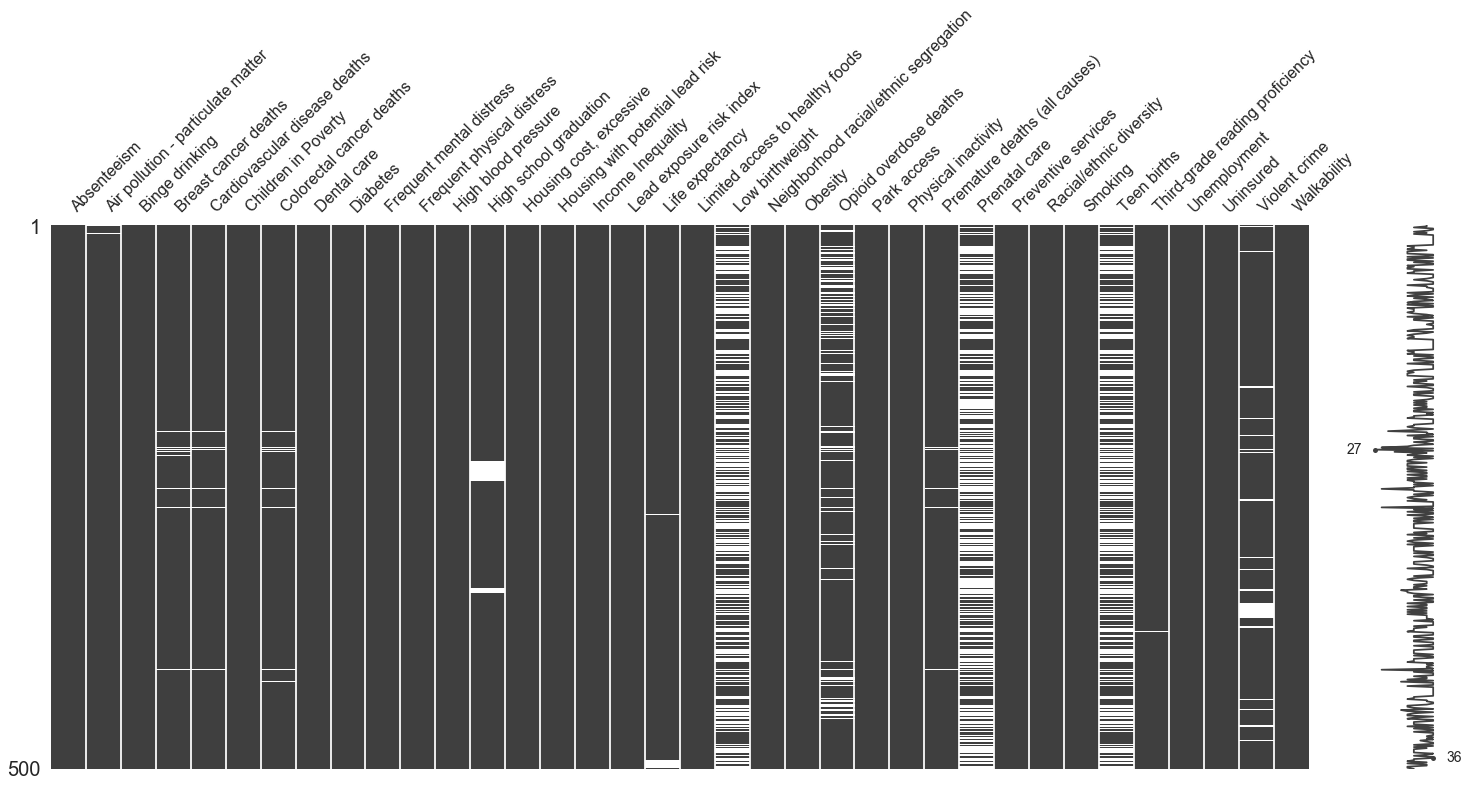

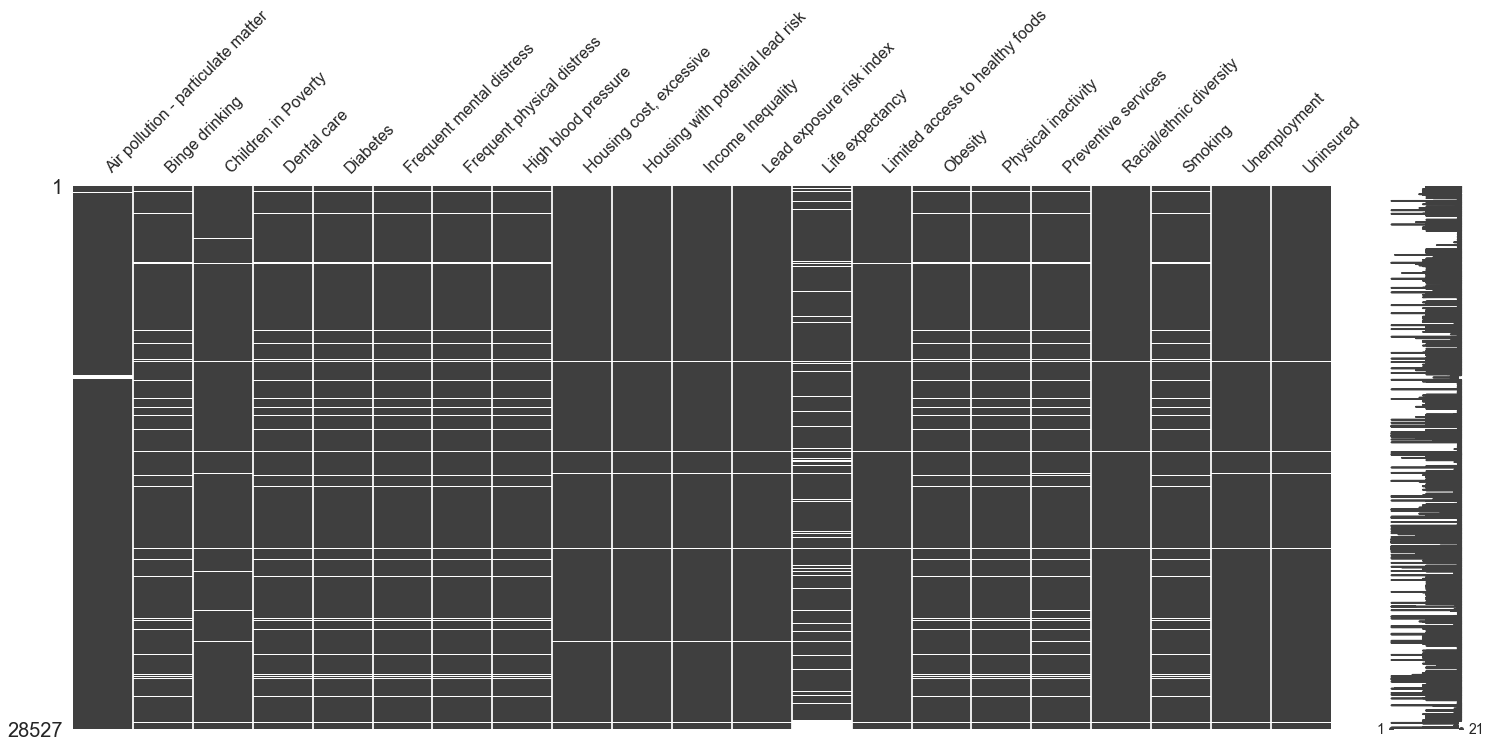

In [12]:
msno.matrix(city_table)
msno.matrix(tract_table)

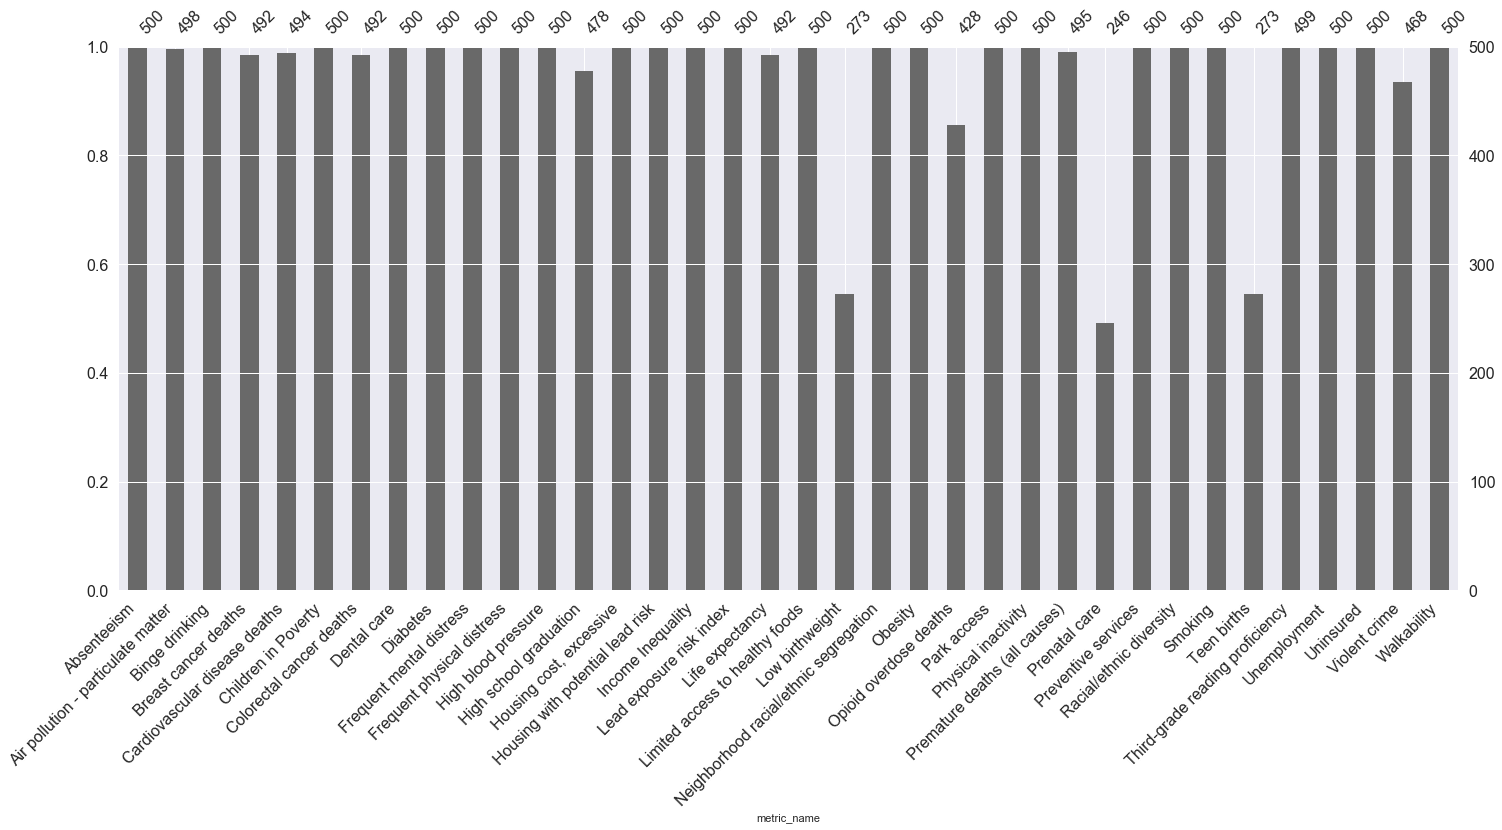

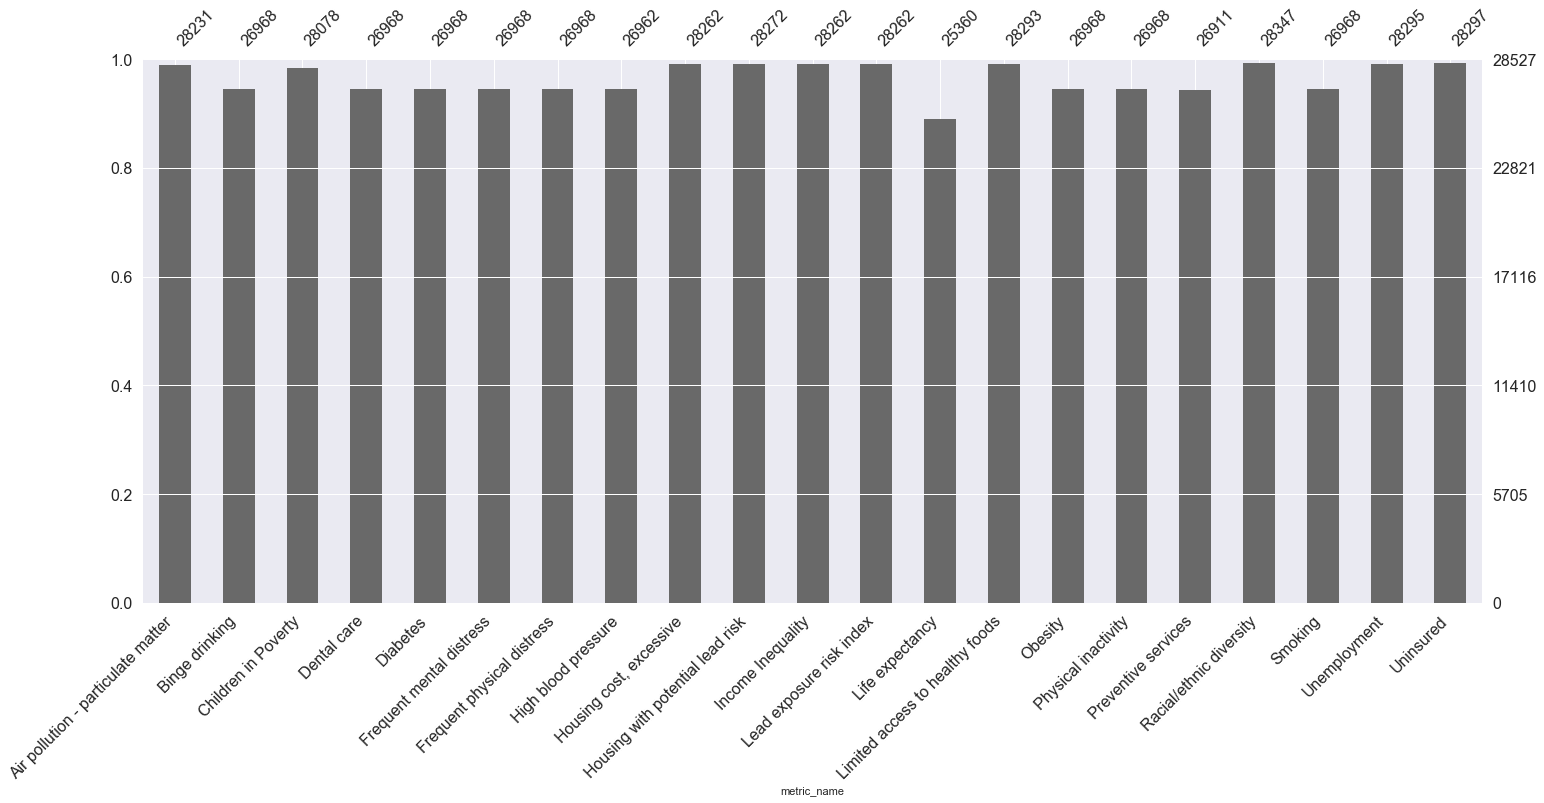

In [13]:
msno.bar(city_table)
plt.show()
msno.bar(tract_table)

# Missing data correlation heatmaps
The below heatmaps show how missing data is related among the variables. 
    <p>A value of -1 means that if one variable appears the other definitely does not. </p>
    <p>A value of 0 means that variables appearing or not appearing have no effect on one another. </p>
    <p>A value of 1 means that if one variable apppears the other definitely also does. </p>

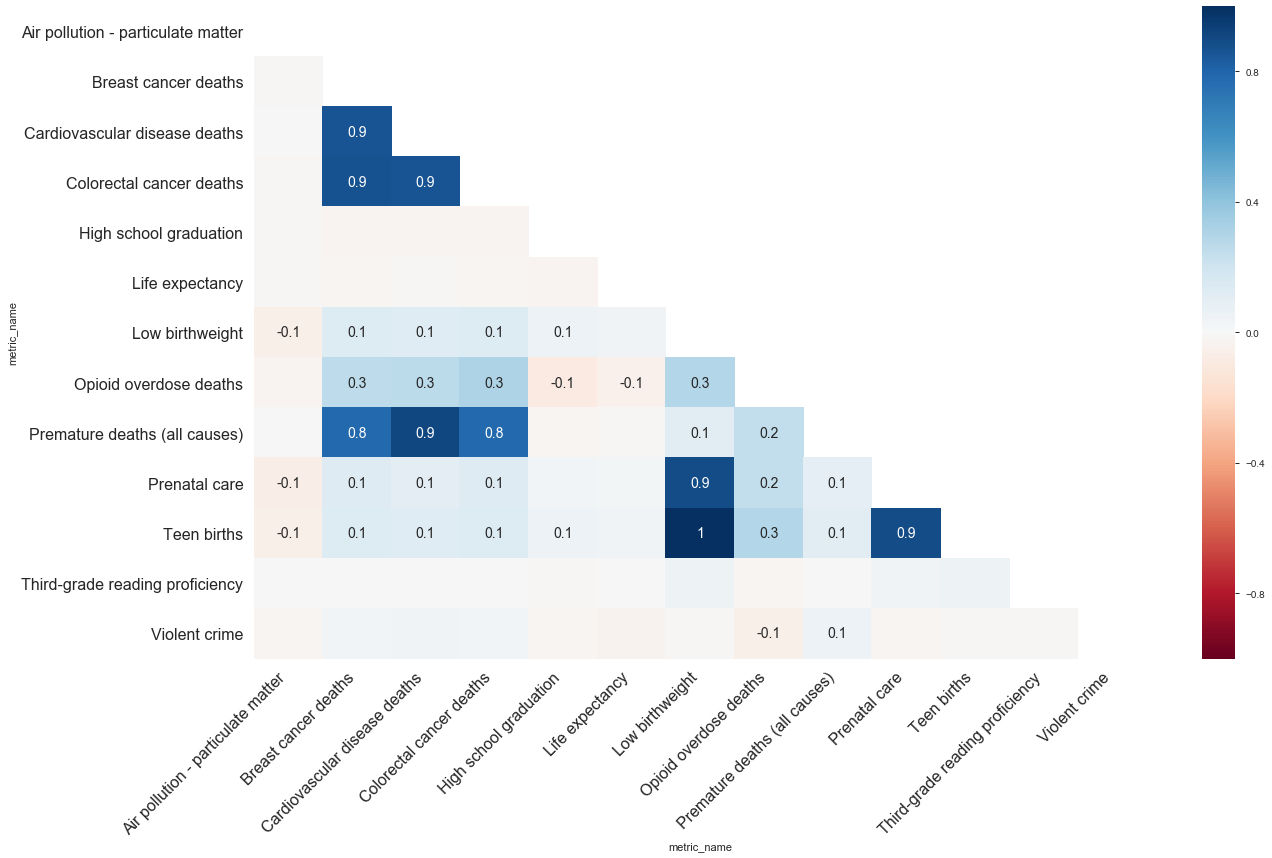

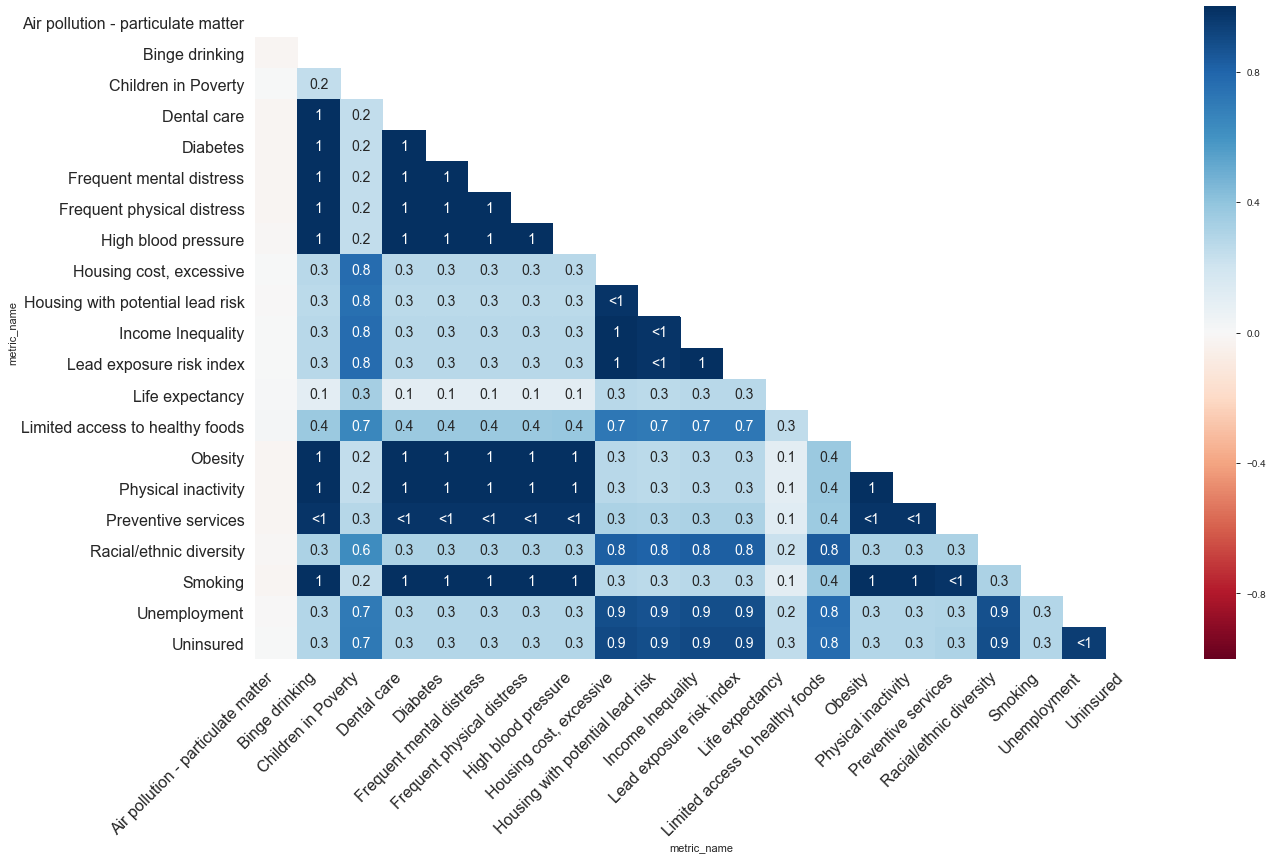

In [14]:
msno.heatmap(city_table)
plt.show()
msno.heatmap(tract_table)

### City table data
Correlated missing values:
Cancer related deaths and premature deaths
if teen births is missing so is low birthweight 100% of the time, prenatal care is pretty close to this

### Tract table data
dental care, diabetes, frequent mental distress, frequent physical distress, high blood pressure, obesity, phyiscal inactivity, preventative services (need to look into), and smoking
All are predictive of one another that if they are missing data so are the others.

Housing variables (Housing cost, excessive; Housing with potential lead risk, lead exposure risk index, and income inequality)

Looks like most of these would be in places where the dataset comes from the same source, so when they are missing it is because they are missing it from that city for all measures from that single source.


In [15]:
sub_tract_table = tract_table.loc[:,['Preventive services', 'Binge drinking', 'Dental care', 'Diabetes',
                   'Frequent mental distress', 'Frequent physical distress', 'High blood pressure', 'Obesity',
                   'Physical inactivity']]
ps_null = sub_tract_table[sub_tract_table['Preventive services'].isnull()]
bd_notnull = sub_tract_table[sub_tract_table['Binge drinking'].notnull()]
ps_null[sub_tract_table['Binge drinking'].notnull()]

C:\Users\Billy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


metric_name,Preventive services,Binge drinking,Dental care,Diabetes,Frequent mental distress,Frequent physical distress,High blood pressure,Obesity,Physical inactivity
stcotr_fips,,,,,,,,,
1097003605,NaN,23.9,67.3,1.4,17.3,6.1,9.8,21.8,16.8
1117030212,NaN,22.1,67.1,4.6,12.5,8.1,19.9,34.6,19.1
1125010102,NaN,21.9,73.3,6.9,13.8,11.3,26.8,27.8,19.8
6037265301,NaN,21.1,64.7,1.2,14.3,4.9,6.1,11.7,13.0
6037402404,NaN,31.3,75.9,0.8,12.0,3.7,5.1,11.4,8.7
6071007601,NaN,18.0,34.4,9.6,21.3,17.2,25.3,35.6,32.2
6073003800,NaN,30.0,51.8,2.7,16.3,7.8,8.7,20.4,17.5
6073009901,NaN,25.5,35.8,3.9,21.3,11.9,12.3,26.0,24.5
6073011300,NaN,39.0,72.4,1.5,11.1,4.3,9.7,14.8,10.1


# Dendrogram

Uses hierarchical clustering algorithm to bin variables against one another by their nulity correlation (measured in terms of binary distance)

Cluster leaves which linked together at a distance of zero fully predict one another's presence

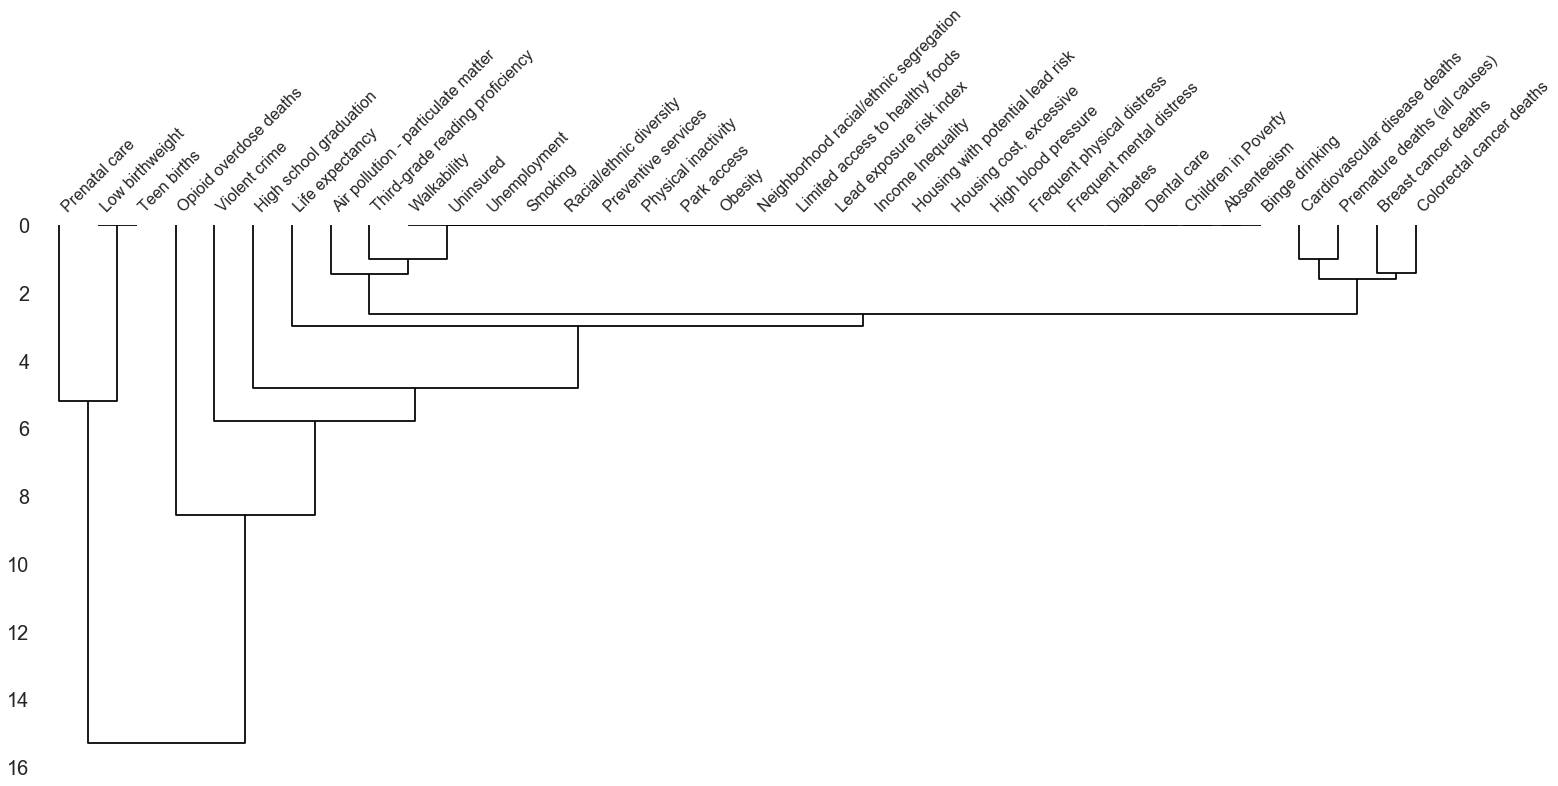

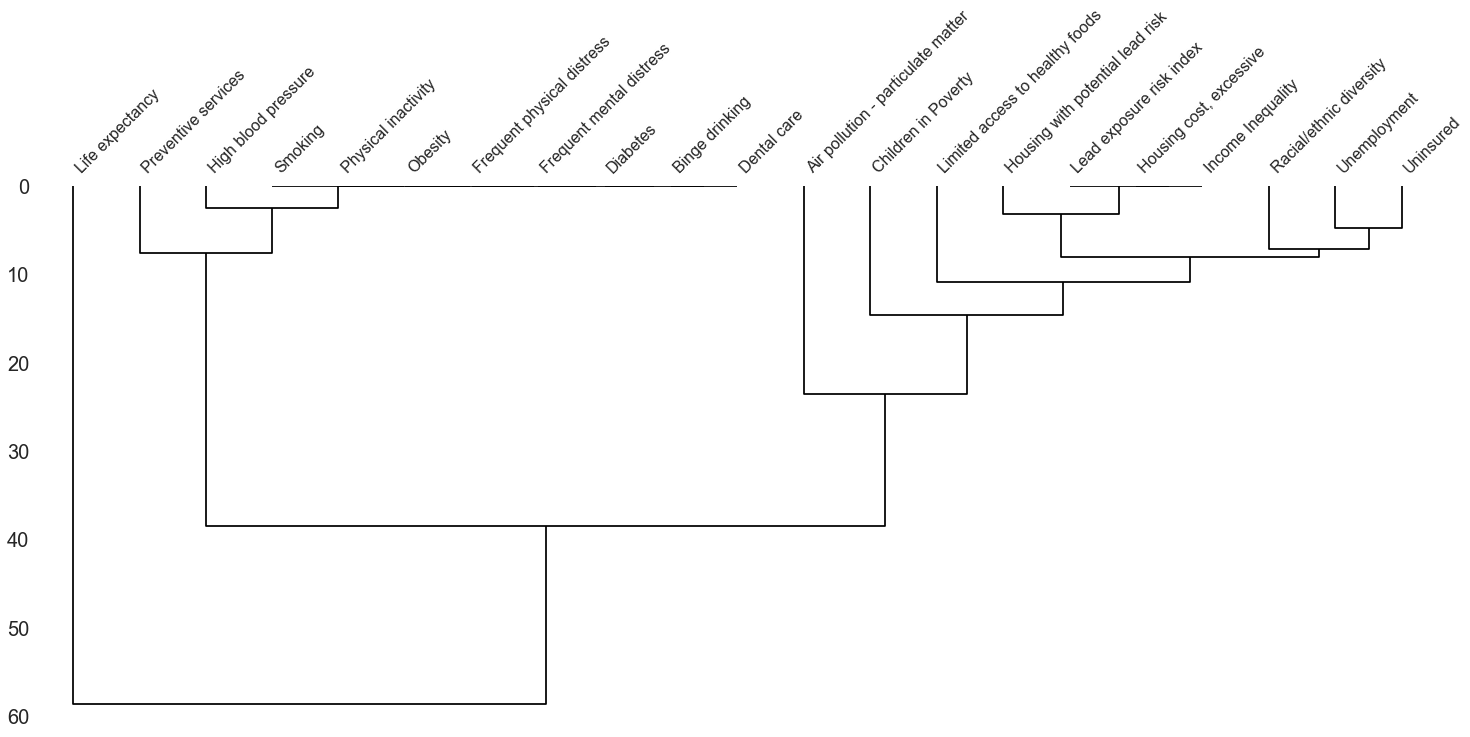

In [16]:
msno.dendrogram(city_table)
plt.show()
msno.dendrogram(tract_table)

A similar conclusion can be drawn from the above trees.

In [17]:
city_profile = city_table.profile_report(title = 'City_profile',style={'full_width':True})
tract_profile = tract_table.profile_report(title= 'Tract_profile',style={'full_width':True})
city_profile.to_file(output_file='../data/manipulated_data/city_output.html')
tract_profile.to_file(output_file='../data/manipulated_data/tract_output.html')

## Removal of missing values

#### City
The following have extremely high rates of missing values (approximately 50%)
<p>- Teen Births</p>
<p>- Prenatal Care</p>
<p>- Low Birthweight</p>

In [18]:
city_table2 = city_table.drop(['Teen births','Prenatal care','Low birthweight'],axis=1)

Strict dropping of all rows that are missing values. Goal: go back and try to impute missing values instead of dropping entire rows because we lose 135 rows from city level and 4,624 from tract data

In [19]:
city_table_sdropped = city_table2.dropna()
tract_table_sdropped = tract_table.dropna()
print(len(city_table2))
print(len(city_table_sdropped))
print(len(tract_table))
len(tract_table_sdropped)

500
365
28527


23903

## Computation of missing values

In [30]:
x_city = city_table_sdropped.copy()
x_city_missing = x_city.copy()

ix = [(row, col) for row in range(x_city_missing.shape[0]) for col in range(x_city_missing.shape[1])]
for row, col in random.sample(ix, int(round(.0724*len(ix)))):
    x_city_missing.iat[row, col] = np.nan
x_tract = tract_table_sdropped.copy()
x_tract_missing = x_tract.copy()

ix2 = [(row, col) for row in range(x_tract_missing.shape[0]) for col in range(x_tract_missing.shape[1])]
for row, col in random.sample(ix2, int(round(.03493532442948785*len(ix2)))):
    x_tract_missing.iat[row, col] = np.nan

In [21]:
x_city_tr, x_city_test = train_test_split(x_city_missing,train_size=.8,shuffle=False)
comp_city_tr, comp_city_test = train_test_split(np.array(x_city),train_size=.8,shuffle=False)
x_tract_tr, x_tract_test = train_test_split(x_tract_missing,train_size=.8,shuffle=False)
comp_tract_tr, comp_tract_test = train_test_split(np.array(x_tract),train_size=.8,shuffle=False)

In [22]:
def imputer_scores(estimator, df_miss_tr, df_miss_test, df_full_tr, df_full_test, strategy=None):
    if estimator == SimpleImputer:
        model = SimpleImputer(missing_values=np.nan, strategy=strategy)
    else:
        model = estimator()
    model_fit = model.fit(df_miss_tr)
    filled = model_fit.transform(df_miss_tr)
    filled2 = model_fit.transform(df_miss_test)
    tr_mse = mse(df_full_tr,filled)
    test_mse = mse(df_full_test,filled2)
    return('train: '+str(tr_mse), 'test: '+str(test_mse))

#### Simple Imputer

In [23]:
print(imputer_scores(SimpleImputer, x_city_tr, x_city_test, comp_city_tr, comp_city_test, 
                     strategy='median'))
print(imputer_scores(SimpleImputer, x_city_tr, x_city_test, comp_city_tr, comp_city_test, 
                     strategy='mean'))
print(imputer_scores(SimpleImputer, x_tract_tr, x_tract_test, comp_tract_tr, comp_tract_test, 
                     strategy='median'))
imputer_scores(SimpleImputer, x_tract_tr, x_tract_test, comp_tract_tr, comp_tract_test, 
                     strategy='mean')

('train: 18122.932006019095', 'test: 25243.991369863008')
('train: 18518.069618054902', 'test: 23590.289332923545')
('train: 6.953218005217386', 'test: 6.955900289837752')


('train: 6.848208949707444', 'test: 6.917841324519425')

#### Iterative Imputer

In [24]:
print(imputer_scores(IterativeImputer, x_city_tr,x_city_test, comp_city_tr, comp_city_test))
imputer_scores(IterativeImputer, x_tract_tr,x_tract_test, comp_tract_tr, comp_tract_test)

('train: 2504.0366037820686', 'test: 2084.76382053909')


('train: 2.6373510766417168', 'test: 3.3048257603514903')

#### KNN calculation

In [25]:
filled_knn = KNN(k=3).fit_transform(x_city_missing)
mse(x_city, filled_knn)

Imputing row 1/365 with 1 missing, elapsed time: 0.109
Imputing row 101/365 with 2 missing, elapsed time: 0.125
Imputing row 201/365 with 1 missing, elapsed time: 0.141
Imputing row 301/365 with 6 missing, elapsed time: 0.156


5787.016771906469

In [26]:
#this crashes my computer. Do NOT run.
# filled_knn2 = KNN(k=3).fit_transform(x_tract_missing)
# mse(x_tract, filled_knn2)

#### SoftImpute

In [40]:
x_city_mdropped = x_city_missing.drop('Lead exposure risk index', axis=1)
x_city_dropped = x_city.drop('Lead exposure risk index', axis=1)
city_normalized = BiScaler().fit_transform(np.array(x_city_mdropped))
city_filled_soft = SoftImpute().fit_transform(city_normalized)
mse(np.array(x_city_dropped), city_filled_soft)

[BiScaler] Initial log residual value = 18.410876
[BiScaler] Iter 1: log residual = 1.698090, log improvement ratio=16.712785
[BiScaler] Iter 2: log residual = -0.438562, log improvement ratio=2.136652
[BiScaler] Iter 3: log residual = -2.806540, log improvement ratio=2.367978
[BiScaler] Iter 4: log residual = -5.227730, log improvement ratio=2.421190
[BiScaler] Iter 5: log residual = -7.651496, log improvement ratio=2.423766
[BiScaler] Iter 6: log residual = -10.069436, log improvement ratio=2.417940
[BiScaler] Iter 7: log residual = -12.480837, log improvement ratio=2.411401
[BiScaler] Iter 8: log residual = -14.886021, log improvement ratio=2.405184
[BiScaler] Iter 9: log residual = -17.285262, log improvement ratio=2.399241
[BiScaler] Iter 10: log residual = -19.678720, log improvement ratio=2.393458
[BiScaler] Iter 11: log residual = -22.066508, log improvement ratio=2.387789
[BiScaler] Iter 12: log residual = -24.448749, log improvement ratio=2.382241
[BiScaler] Iter 13: log resi

2141746.75897876

In [43]:
city_table_columns = city_table.columns
tract_table_columns = tract_table.columns
city_table_index = city_table.index
tract_table_index = tract_table.index

### Best Imputer appears to be Iterative Imputer

In [51]:
iterative_imp = IterativeImputer()
city_table_filled = iterative_imp.fit_transform(city_table)
tract_table_filled = iterative_imp.fit_transform(tract_table)
city_filled_df = pd.DataFrame(city_table_filled, columns=city_table_columns, index=city_table_index)
tract_filled_df = pd.DataFrame(tract_table_filled, columns=tract_table_columns, index=tract_table_index)
tract_filled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28527 entries, 1073000100 to 56021980801
Data columns (total 21 columns):
Air pollution - particulate matter    28527 non-null float64
Binge drinking                        28527 non-null float64
Children in Poverty                   28527 non-null float64
Dental care                           28527 non-null float64
Diabetes                              28527 non-null float64
Frequent mental distress              28527 non-null float64
Frequent physical distress            28527 non-null float64
High blood pressure                   28527 non-null float64
Housing cost, excessive               28527 non-null float64
Housing with potential lead risk      28527 non-null float64
Income Inequality                     28527 non-null float64
Lead exposure risk index              28527 non-null float64
Life expectancy                       28527 non-null float64
Limited access to healthy foods       28527 non-null float64
Obesity                    

In [45]:
city_filled_df['Lead exposure risk index'] = city_filled_df['Lead exposure risk index'].astype('category')
tract_filled_df['Lead exposure risk index'] = tract_filled_df['Lead exposure risk index'].astype('category')

In [65]:
first_features_city = city_filled_df.iloc[:, :18]
second_features_city = city_filled_df.iloc[:,18:]
first_features_tract = tract_filled_df.iloc[:, :11]
second_features_tract = tract_filled_df.iloc[:, 11:]

# Correlation

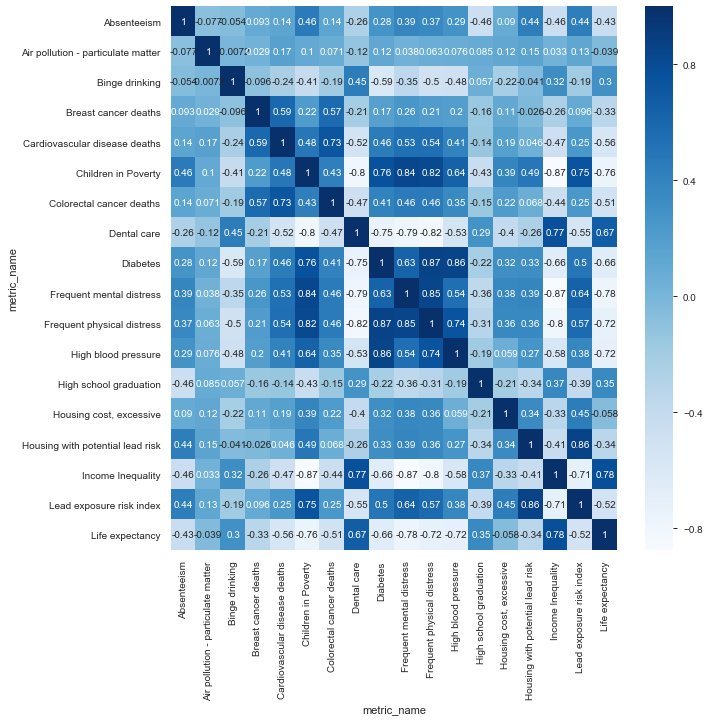

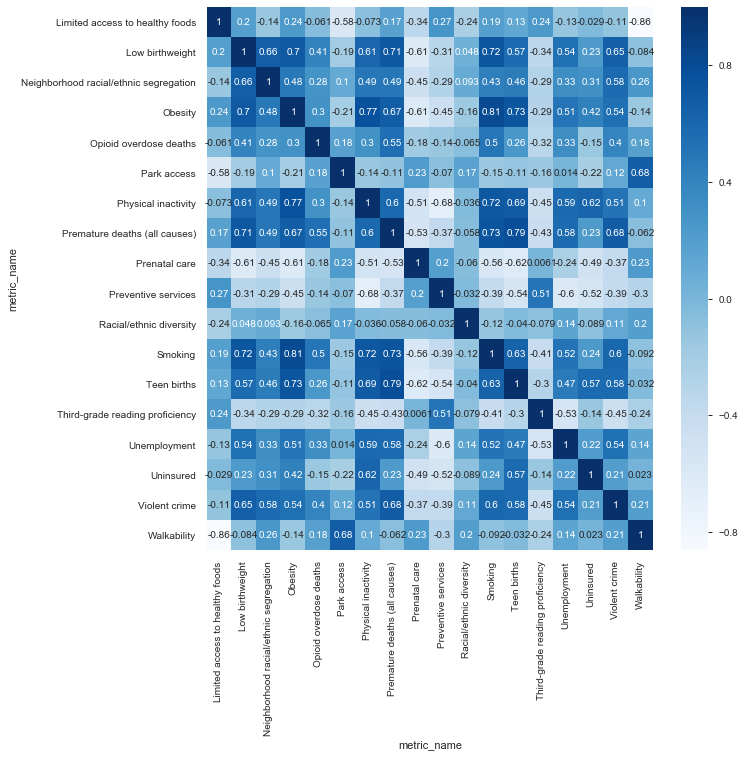

In [66]:
plt.figure(figsize=(10,10))
sns.heatmap(first_features_city.corr(), cmap='Blues', annot=True)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(second_features_city.corr(), cmap='Blues', annot=True)

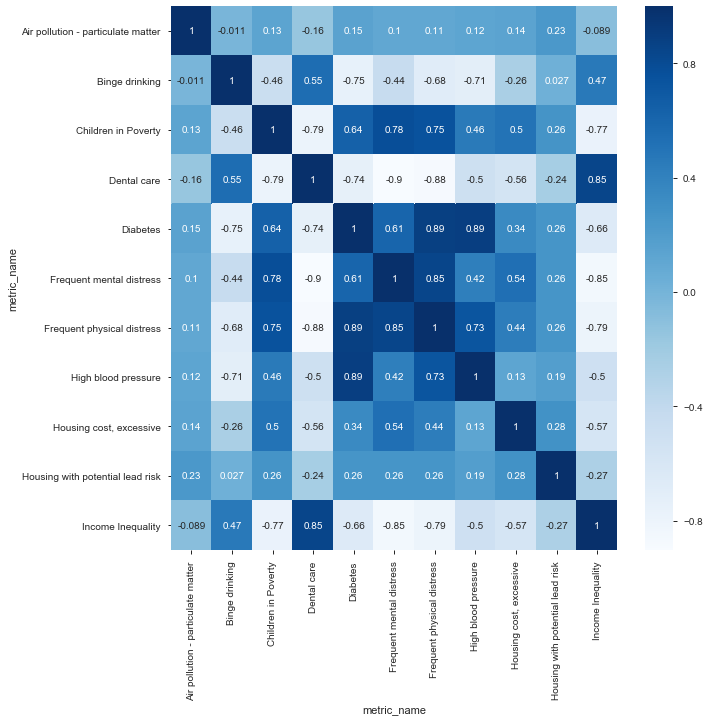

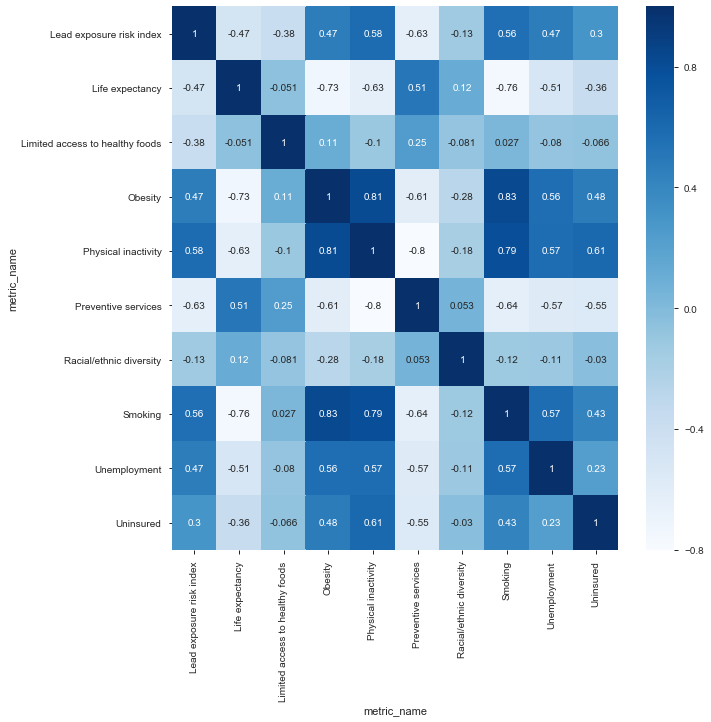

In [54]:
plt.figure(figsize=(10,10))
sns.heatmap(first_features_tract.corr(), cmap='Blues', annot=True)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(second_features_tract.corr(), cmap='Blues', annot=True)

#### Tract Data
Physical_inactivity is highly correlated with Frequent_physical_distress (ρ = 0.9160439931) 

In [55]:
tract_filled_df2 = tract_filled_df.drop('Frequent physical distress', axis=1)

# Outliers

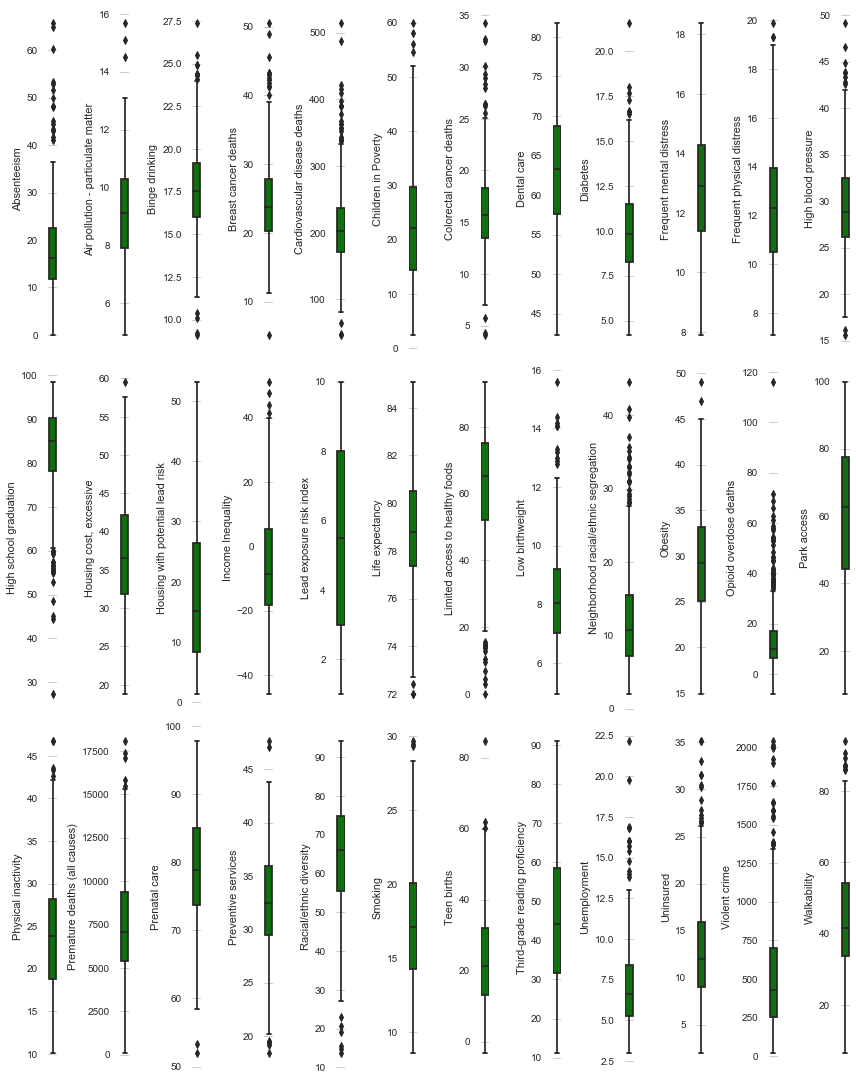

In [59]:
l = city_filled_df.columns.values
number_of_columns=12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(city_filled_df[l[i]],color='green',orient='v')
    plt.tight_layout()

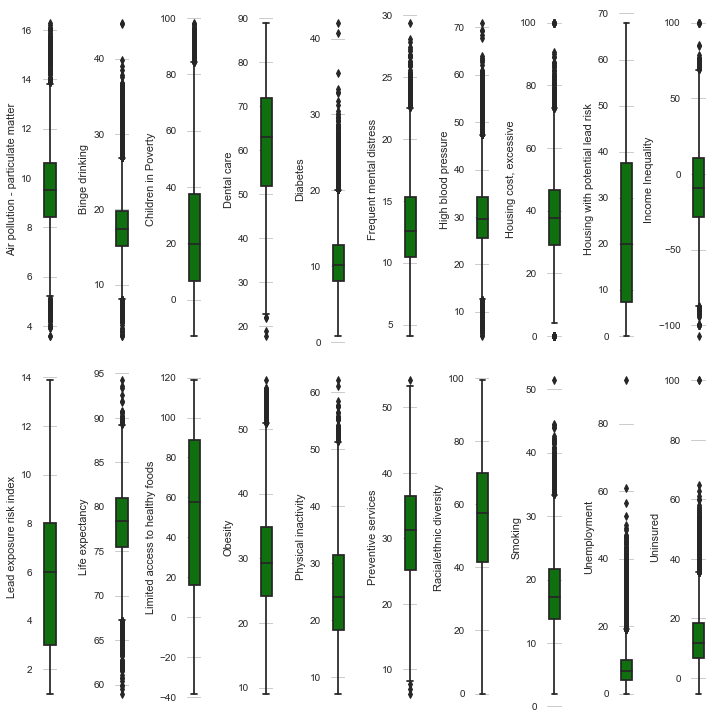

In [62]:
l2 = tract_filled_df2.columns.values
number_of_columns2=10
number_of_rows2 = len(l2)-1/number_of_columns2
plt.figure(figsize=(number_of_columns2,5*number_of_rows2))
for i in range(0,len(l2)):
    plt.subplot(number_of_rows2 + 1,number_of_columns2,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(tract_filled_df2[l2[i]],color='green',orient='v')
    plt.tight_layout()